# Model Predictive Control (MPC) for a Mass-Spring-Damper System

This notebook provides a detailed walkthrough of designing and simulating a Model Predictive Controller (MPC) for a simple mass-spring-damper system, as depicted in the problem image on the slides.



### Problem Description

We have a mechanical system consisting of a payload on a platform, which can be modeled as a single mass `m`. This mass is connected to the floor by a spring with stiffness `k` and a damper with damping coefficient `b`. An actuator can apply a force `u(t)` to the mass. A sensor measures the state of the system, which consists of its position and velocity:
$$ x(t) = \begin{bmatrix} \text{position} \\ \text{velocity} \end{bmatrix} = \begin{bmatrix} p(t) \\ \dot{p}(t) \end{bmatrix} $$

**Our goal is to design a controller that drives the system to its equilibrium point (zero position, zero velocity) from any initial state, while respecting constraints on the actuator.** This is a classic regulation problem. We will use MPC, which is an advanced control technique ideal for handling such problems with constraints.

### Step 1: System Modeling and Discretization

First, we need to create a mathematical model of the system. We can do this by applying Newton's second law ($F=ma$). According to Newton's law, this sum equals mass times acceleration ($\ddot{p}(t)$):

$$ m \ddot{p}(t) = -k p(t) - b \dot{p}(t) + u(t) $$

Rearranging the equation, we get the standard state-space form, $\dot{x}(t) = A x(t) + B u(t)$, where $x(t) = [p(t), \dot{p}(t)]^T$.

$$ \dot{x}(t) = \begin{bmatrix} \dot{p}(t) \\ \ddot{p}(t) \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ -\frac{k}{m} & -\frac{b}{m} \end{bmatrix} \begin{bmatrix} p(t) \\ \dot{p}(t) \end{bmatrix} + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} u(t) $$

In [1]:
###############################################################################
## Import necessary libraries
################################################################################ 
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

###############################################################################
## MODEL PARAMETERS AND DYNAMICS
###############################################################################
def modelParameters():
    p = {}
    # parameter 				description 	         [unit] 				 
    p['m'] = 30		            # mass			         [kg]                                
    p['k'] = 4.0e2	            # spring coefficient     [N/m] 					   
    p['b'] = 1.0e2 		        # damping coefficient	 [N s/m] 					 		
    return p

###############################################################################
## MODEL DYNAMICS
###############################################################################
def f(x, u, p, h):
    """
    Defines the differential equations of the mass-spring-damper model.
    This function calculates the rate of change of the state variables.
    """
    # Define state space matrices
    A = ca.DM([[0, 1], [-p['k']/p['m'], -p['b']/p['m']]])
    B = ca.DM([[0], [1/p['m']]])
    
    # State derivatives [dx1/dt, dx2/dt]
    return A @ x + B @ u

def g(x, u, p, h):
    """
    Measurement function. Converts the state vector into the output vector.
    """
    y = ca.vertcat(
        x[0],                     # y: position in m
    )
    return y

###############################################################################
## RUNGE-KUTTA INTEGRATION
###############################################################################
def fd(x, u, p, h):
    """
    Discrete-time state transition function using 4th-order Runge-Kutta integration.
    h: sample period
    """
    k1 = f(x, u, p, h)
    k2 = f(x + h/2 * k1, u, p, h)
    k3 = f(x + h/2 * k2, u, p, h)
    k4 = f(x + h * k3, u, p, h)
    x_next = x + h/6 * (k1 + 2*k2 + 2*k3 + k4)
    return x_next


In [2]:
###############################################################################
## DEFINE SIMULATION PARAMETERS
###############################################################################
# Define a dictionary 'ops' to hold simulation options and parameters
ops = {}
ops['nx'] = 2      # Number of states
ops['ny'] = 2      # Number of outputs
ops['nu'] = 1      # Number of controllable inputs
ops['h']  = 0.01  # Sample period in seconds  

ops['t'] = np.arange(0, 2, ops['h'])  # Time vector, simulate for 2 seconds
ops['N'] = len(ops['t'])  # Number of simulation steps
ops['Np'] = 20  # Prediction horizon (e.g., 20 steps, 0.2 seconds)

ops['x0'] = np.array([-0.03, -0.1])  # Initial state [position, velocity]

# systems constraints
PMin = -0.04  # Minimum displacement [m]
PMax =  0.04  # Maximum displacement [m]
VMin = -0.50  # Minimum velocity [m/s]
VMax =  0.50  # Maximum velocity [m/s]
CMin = -200   # Minimum control force [N]
CMax =  200   # Maximum control force [N]

# state constraints vector
ops['x_min']   = np.array([PMin, VMin])
ops['x_max']   = np.array([PMax, VMax])
# control input constraints vector
ops['u_min']   = np.array([CMin])
ops['u_max']   = np.array([CMax])

#### Simulation of Control-Free Scenario 
In the following session, we simulate the system when no control action is applied. 

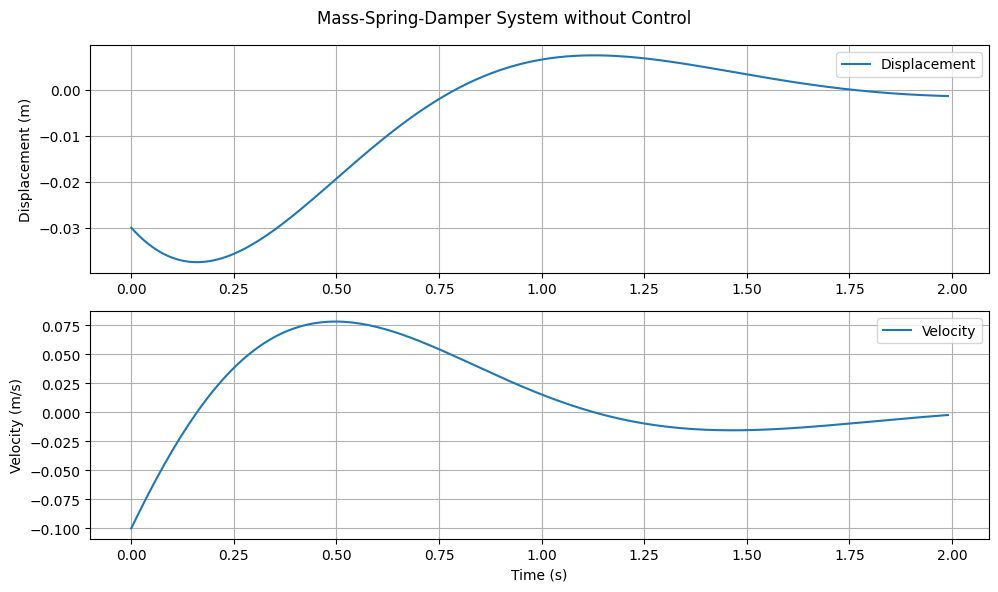

In [3]:
# Load model parameters
p = modelParameters()

# Simulate with no control
x_free = np.zeros((ops['nx'], ops['N'] + 1))
x_free[:, 0] = ops['x0']

for k in range(ops['N']):
    x_next = fd(x_free[:, k], 0, p, ops['h']).full().flatten()
    x_free[:, k + 1] = x_next

# Plot results
t = ops['t']
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, x_free[0, :ops['N']], label='Displacement')
plt.ylabel('Displacement (m)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, x_free[1, :ops['N']], label='Velocity')
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (s)')
plt.legend()
plt.grid(True)

plt.suptitle('Mass-Spring-Damper System without Control')
plt.tight_layout()
plt.show()

### Step 2: MPC Controller


In [4]:
import time
# Load model parameters from the separate file
p = modelParameters()

# Define symbolic variables within Opti environment
opti = ca.Opti() # Set up Opti environment for NMPC
X = opti.variable(ops['nx'], int(ops['Np']) + 1)  # State trajectory
U = opti.variable(ops['nu'], int(ops['Np']))      # Control inputs
x0_param = opti.parameter(ops['nx']) # Parameter for initial state

# Define objective function
obj = 0   # Initialize Objective
Q = ca.MX.eye(ops['nx']) * [1e8, 1e4]  # Higher weight on displacement
R = ca.MX.eye(ops['nu'])               # Lower weight on control effort
# Objective accumulation
for i in range(ops['Np']):
    x_next = fd(X[:, i], U[:, i], p, ops['h'])
    opti.subject_to(X[:, i+1] == x_next)
    obj += ca.mtimes([X[:, i].T, Q, X[:, i]]) + ca.mtimes([U[:, i].T, R, U[:, i]])
opti.minimize(obj) # Minimize objective

opti.subject_to(X[:, 0] == x0_param) # Initial state constraint
# Input constraints and state constraints
for i in range(int(ops['Np'])):
    opti.subject_to(U[:, i] >= ops['u_min'])
    opti.subject_to(U[:, i] <= ops['u_max'])
    opti.subject_to(X[:, i] >= ops['x_min'])
    opti.subject_to(X[:, i] <= ops['x_max'])

# Solver
opti.solver('ipopt', {'ipopt': {'print_level': 5, 'max_iter': 1000}})

# Simulate with MPC
x_sim = np.zeros((ops['nx'], ops['N'] + 1))
u_sim = np.zeros((ops['nu'], ops['N']))
x_sim[:, 0] = ops['x0']  # Initial state

# Start timer
start_time = time.time()
for k in range(ops['N']):
    # Set parameter (current state)
    opti.set_value(x0_param, x_sim[:, k])
    
    # Solve
    try:
        sol = opti.solve() # Solve the optimization problem
        u_sim[:, k] = sol.value(U[:, 0])  # Apply the first control input
        # Simulate next state
        x_next = fd(x_sim[:, k], u_sim[:, k], p, ops['h']).full().flatten()
        x_sim[:, k + 1] = x_next
    except Exception as e:
        print(f"Error at step {k}: {e}")
        break
# End timer
end_time = time.time() 
# Compute average time per loop
total_time = end_time - start_time
average_time = total_time / ops['N']

print(f"Average computation time per loop: {average_time:.6f} seconds") 


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      162
Number of nonzeros in inequality constraint Jacobian.:      120
Number of nonzeros in Lagrangian Hessian.............:       60

Total number of variables............................:       62
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       42
Total number of inequality c

### Results and Visualization

Now we plot the results of our simulation. We want to see:
1.  **State Trajectories**: How the position and velocity of the mass change over time. We expect them to converge to zero.
2.  **Control Input**: The force applied by the actuator over time. We expect it to stay within the specified constraints (`u_min`, `u_max`).

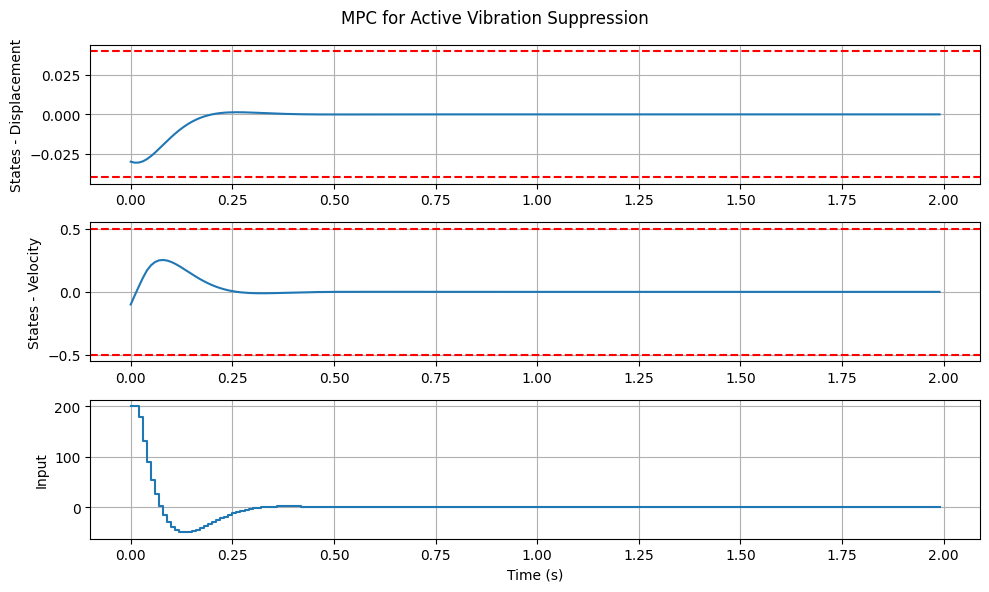

In [5]:
# Time vector
t = ops['t']

# Plot results
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(t, x_sim[0, :ops['N']], label='Displacement')
plt.axhline(y=ops['x_min'][0], color='r', linestyle='--')
plt.axhline(y=ops['x_max'][0], color='r', linestyle='--')
plt.ylabel('States - Displacement')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, x_sim[1, :ops['N']], label='Velocity')
plt.axhline(y=ops['x_min'][1], color='r', linestyle='--')
plt.axhline(y=ops['x_max'][1], color='r', linestyle='--')
plt.ylabel('States - Velocity')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.step(t, u_sim[0, :], label='Control u')
plt.ylabel('Input')
plt.xlabel('Time (s)')
plt.grid(True)

plt.suptitle('MPC for Active Vibration Suppression')
plt.tight_layout()
plt.show()

## Nonlinear MPC 

In this section, we consider a nonlinear mass-spring-damper system, where the spring is nonlinear.

In [6]:
###############################################################################
## MODEL DYNAMICS WITH NONLINEAR SPRING
###############################################################################
def f_nl(x, u, p, h):
    """
    Defines the differential equations of the mass-spring-damper model.
    This function calculates the rate of change of the state variables.
    """
    # State derivatives [dx1/dt, dx2/dt]
    ki = ca.vertcat(
        x[1],
        - p['k'] * 1e4 * x[0]**3 / p['m'] - p['b'] * x[1] / p['m'] + 1/p['m'] * u,
    )
    return ki


###############################################################################
## RUNGE-KUTTA INTEGRATION
###############################################################################
def fd_nl(x, u, p, h):
    """
    Discrete-time state transition function using 4th-order Runge-Kutta integration.
    h: sample period
    """
    k1 = f_nl(x, u, p, h)
    k2 = f_nl(x + h/2 * k1, u, p, h)
    k3 = f_nl(x + h/2 * k2, u, p, h)
    k4 = f_nl(x + h * k3, u, p, h)
    x_next = x + h/6 * (k1 + 2*k2 + 2*k3 + k4)
    return x_next

Let's first simulate the control-free case.

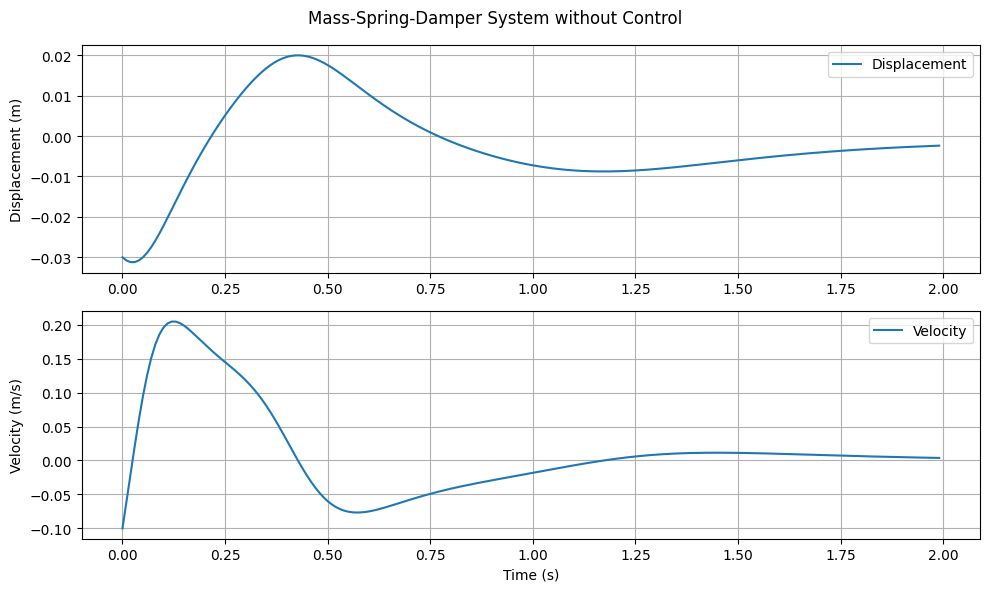

In [7]:
# Load model parameters
p = modelParameters()

# Simulate with no control
x_free = np.zeros((ops['nx'], ops['N'] + 1))
x_free[:, 0] = ops['x0']

for k in range(ops['N']):
    x_next = fd_nl(x_free[:, k], 0, p, ops['h']).full().flatten()
    x_free[:, k + 1] = x_next

# Plot results
t = ops['t']
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, x_free[0, :ops['N']], label='Displacement')
plt.ylabel('Displacement (m)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, x_free[1, :ops['N']], label='Velocity')
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (s)')
plt.legend()
plt.grid(True)

plt.suptitle('Mass-Spring-Damper System without Control')
plt.tight_layout()
plt.show()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      162
Number of nonzeros in inequality constraint Jacobian.:      120
Number of nonzeros in Lagrangian Hessian.............:      120

Total number of variables............................:       62
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       42
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

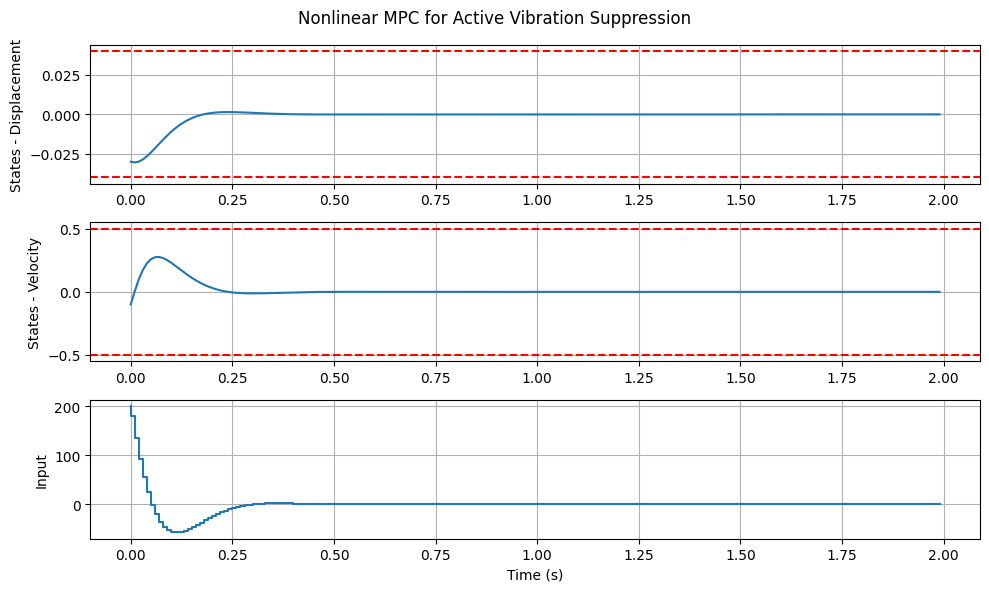

In [8]:
# Load model parameters from the separate file
p = modelParameters()

# Define symbolic variables within Opti environment
opti = ca.Opti() # Set up Opti environment for NMPC
X = opti.variable(ops['nx'], int(ops['Np']) + 1)  # State trajectory
U = opti.variable(ops['nu'], int(ops['Np']))      # Control inputs
x0_param = opti.parameter(ops['nx']) # Parameter for initial state

# Define objective function
obj = 0   # Initialize Objective
Q = ca.MX.eye(ops['nx']) * [1e8, 1e4]  # Higher weight on displacement
R = ca.MX.eye(ops['nu'])               # Lower weight on control effort
# Objective accumulation
for i in range(ops['Np']):
    x_next = fd_nl(X[:, i], U[:, i], p, ops['h'])
    opti.subject_to(X[:, i+1] == x_next)
    obj += ca.mtimes([X[:, i].T, Q, X[:, i]]) + ca.mtimes([U[:, i].T, R, U[:, i]])
opti.minimize(obj) # Minimize objective

opti.subject_to(X[:, 0] == x0_param) # Initial state constraint
# Input constraints and state constraints
for i in range(int(ops['Np'])):
    opti.subject_to(U[:, i] >= ops['u_min'])
    opti.subject_to(U[:, i] <= ops['u_max'])
    opti.subject_to(X[:, i] >= ops['x_min'])
    opti.subject_to(X[:, i] <= ops['x_max'])

# Solver
opti.solver('ipopt', {'ipopt': {'print_level': 5, 'max_iter': 1000}})

# Simulate with MPC
x_sim = np.zeros((ops['nx'], ops['N'] + 1))
u_sim = np.zeros((ops['nu'], ops['N']))
x_sim[:, 0] = ops['x0']  # Initial state

# Start timer
start_time = time.time()
for k in range(ops['N']):
    # Set parameter (current state)
    opti.set_value(x0_param, x_sim[:, k])
    
    # Solve
    try:
        sol = opti.solve() # Solve the optimization problem
        u_sim[:, k] = sol.value(U[:, 0])  # Apply the first control input
        # Simulate next state
        x_next = fd_nl(x_sim[:, k], u_sim[:, k], p, ops['h']).full().flatten()
        x_sim[:, k + 1] = x_next
    except Exception as e:
        print(f"Error at step {k}: {e}")
        break

# End timer
end_time = time.time() 
# Compute average time per loop
total_time = end_time - start_time
average_time = total_time / ops['N']

print(f"Average computation time per loop: {average_time:.6f} seconds") 

# Time vector
t = ops['t']

# Plot results
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(t, x_sim[0, :ops['N']], label='Displacement')
plt.axhline(y=ops['x_min'][0], color='r', linestyle='--')
plt.axhline(y=ops['x_max'][0], color='r', linestyle='--')
plt.ylabel('States - Displacement')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, x_sim[1, :ops['N']], label='Velocity')
plt.axhline(y=ops['x_min'][1], color='r', linestyle='--')
plt.axhline(y=ops['x_max'][1], color='r', linestyle='--')
plt.ylabel('States - Velocity')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.step(t, u_sim[0, :], label='Control u')
plt.ylabel('Input')
plt.xlabel('Time (s)')
plt.grid(True)

plt.suptitle('Nonlinear MPC for Active Vibration Suppression')
plt.tight_layout()
plt.show()